<a href="https://colab.research.google.com/github/aravindchakravarti/Deep_Learning_EVA_4/blob/master/S6_Regularization/EVA4_Session_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
# Import core module
import torch.nn as nn
# We need support for functional programming
import torch.nn.functional as F
import torch.optim as optim
# For MNIST dataset
from torchvision import datasets, transforms
# For Global Average Pooling
from torch.nn import AvgPool2d
# Plotting purpose
%matplotlib inline
import matplotlib.pyplot as plt

# Data Transformations
We first start with defining our data transformations. Image augmentation techniques are great and we need to keep it ready by the time we hit overfitting!

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #  transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.RandomAffine(degrees=10, shear = 10),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train and Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders

In [207]:
# SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
# torch.manual_seed(SEED)

#if cuda:
#    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The Model

I like the model definition like below, not with nn.Sequential() way. So, I am going to keep it same 

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv01 = nn.Conv2d(1, 6, 3, bias=False, padding=1)        #O=28
        self.batch01 = nn.BatchNorm2d(num_features=6)    
        self.conv02 = nn.Conv2d(6, 8, 3, bias=False,padding=1)        #O=28
        self.batch02 = nn.BatchNorm2d(num_features=8)    
        self.conv03 = nn.Conv2d(8, 10, 3, bias=False,padding=1)        #O=28
        self.batch03 = nn.BatchNorm2d(num_features=10)   
        self.conv04 = nn.Conv2d(10, 10, 3, bias=False,padding=0)        #O=26
        self.batch04 = nn.BatchNorm2d(num_features=10)   
        self.pool01 = nn.MaxPool2d(2, 2)                                #O=13
       # self.conv05 = nn.Conv2d(12, 10, 1, bias=False)

        self.conv11 = nn.Conv2d(10, 10, 3, bias=False, padding=1)       #O=13
        self.batch11 = nn.BatchNorm2d(num_features=10)
        self.conv12 = nn.Conv2d(10, 10, 3, bias=False, padding=0)       #O=11
        self.batch12 = nn.BatchNorm2d(num_features=10)
        self.conv13 = nn.Conv2d(10, 14, 3, bias=False, padding=0)       #O=09
        self.batch13 = nn.BatchNorm2d(num_features=14)
        self.conv14 = nn.Conv2d(14, 14, 3, bias=False, padding=0)       #O=07
        self.batch14 = nn.BatchNorm2d(num_features=14)
        self.conv15 = nn.Conv2d(14, 16, 3, bias=False, padding=0)       #O=05
        self.batch15 = nn.BatchNorm2d(num_features=16)
    
        self.avg_pool = nn.AvgPool2d(kernel_size=5)
        self.conv23 = nn.Conv2d(16, 10, 1, bias=False, padding=0)

    def forward(self, x):
        x = self.batch01(F.dropout(F.relu(self.conv01(x)), 0.01))        
        x = self.batch02(F.dropout(F.relu(self.conv02(x)), 0.01))
        x = self.batch03(F.dropout(F.relu(self.conv03(x)), 0.01))
        x = self.batch04(F.dropout(F.relu(self.conv04(x)), 0.01))
        x = self.pool01(x)
        #x = F.relu(self.conv05(x))

        x = self.batch11(F.dropout(F.relu(self.conv11(x)), 0.02))
        x = self.batch12(F.dropout(F.relu(self.conv12(x)), 0.02))
        x = self.batch13(F.dropout(F.relu(self.conv13(x)), 0.02))
        x = self.batch14(F.dropout(F.relu(self.conv14(x)), 0.02))
        x = self.batch15(F.dropout(F.relu(self.conv15(x)), 0.02))

        x = self.avg_pool(x)
        x = F.relu(self.conv23(x))
        x = x.view(-1, 10)                           # Don't want 10x1x1..
        return F.log_softmax(x)

# Model Parameters and other details

In [209]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]              54
       BatchNorm2d-2            [-1, 6, 28, 28]              12
            Conv2d-3            [-1, 8, 28, 28]             432
       BatchNorm2d-4            [-1, 8, 28, 28]              16
            Conv2d-5           [-1, 10, 28, 28]             720
       BatchNorm2d-6           [-1, 10, 28, 28]              20
            Conv2d-7           [-1, 10, 26, 26]             900
       BatchNorm2d-8           [-1, 10, 26, 26]              20
         MaxPool2d-9           [-1, 10, 13, 13]               0
           Conv2d-10           [-1, 10, 13, 13]             900
      BatchNorm2d-11           [-1, 10, 13, 13]              20
           Conv2d-12           [-1, 10, 11, 11]             900
      BatchNorm2d-13           [-1, 10, 11, 11]              20
           Conv2d-14             [-1, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


# Training and Testing

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = [[],[],[],[]]
train_acc = []
test_acc = [[],[],[],[]]

def train(model, device, train_loader, optimizer, epoch, is_L1_loss = False):
  model.train()
  #pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  loss = 0  # <- added by Aravind. Probably we should not add? Not sure yet

  for batch_idx, (data, target) in enumerate(train_loader):
    # get samples
    data, target = data.to(device), target.to(device)
    
    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    reg_loss = 0 

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    if (is_L1_loss == True):
        l1_crit = nn.L1Loss(size_average=False)
        for param in model.parameters(): 
            zero_vector = torch.rand_like(param) * 0
            reg_loss += l1_crit(param,zero_vector) 

        
    factor = 0.0005 
    loss += factor * reg_loss 

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    #pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, select_list = 0):
    '''
    select_list = 0: Test Loss and Test Accuracy without L1 and L2 regularization
    select_list = 1: Test Loss and Test Accuracy with L1 regularization
    select_list = 2: Test Loss and Test Accuracy with L2 regularization
    select_list = 3: Test Loss and Test Accuracy with L1 and L2 regularization
    '''
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses[select_list].append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc[select_list].append(100. * correct / len(test_loader.dataset))

# Train the model

## Without L1/L2 Regularization 

In [233]:
from torch.optim.lr_scheduler import StepLR

model_1 =  Net().to(device)
optimizer = optim.SGD(model_1.parameters(), lr=0.01, momentum=0.9, weight_decay=0)
# scheduler = StepLR(optimizer, step_size=8, gamma=0.95)

EPOCHS = 10
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model_1, device, train_loader, optimizer, epoch, is_L1_loss = False)
    # scheduler.step()
    test(model_1, device, test_loader, select_list=0)

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Average loss: 0.0891, Accuracy: 9765/10000 (97.65%)

EPOCH: 1

Test set: Average loss: 0.0500, Accuracy: 9852/10000 (98.52%)

EPOCH: 2

Test set: Average loss: 0.0376, Accuracy: 9894/10000 (98.94%)

EPOCH: 3

Test set: Average loss: 0.0302, Accuracy: 9906/10000 (99.06%)

EPOCH: 4

Test set: Average loss: 0.0268, Accuracy: 9909/10000 (99.09%)

EPOCH: 5

Test set: Average loss: 0.0291, Accuracy: 9910/10000 (99.10%)

EPOCH: 6

Test set: Average loss: 0.0246, Accuracy: 9921/10000 (99.21%)

EPOCH: 7

Test set: Average loss: 0.0228, Accuracy: 9931/10000 (99.31%)

EPOCH: 8

Test set: Average loss: 0.0241, Accuracy: 9924/10000 (99.24%)

EPOCH: 9

Test set: Average loss: 0.0243, Accuracy: 9921/10000 (99.21%)



## With L1 Regularization

In [0]:
from torch.optim.lr_scheduler import StepLR

model_2 =  Net().to(device)
optimizer = optim.SGD(model_2.parameters(), lr=0.01, momentum=0.9, weight_decay=0)
# scheduler = StepLR(optimizer, step_size=8, gamma=0.95)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model_2, device, train_loader, optimizer, epoch, is_L1_loss=True)
    # scheduler.step()
    test(model_2, device, test_loader, select_list=1)

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0960, Accuracy: 9732/10000 (97.32%)

EPOCH: 1

Test set: Average loss: 0.0616, Accuracy: 9833/10000 (98.33%)

EPOCH: 2

Test set: Average loss: 0.0846, Accuracy: 9754/10000 (97.54%)

EPOCH: 3

Test set: Average loss: 0.0453, Accuracy: 9874/10000 (98.74%)

EPOCH: 4

Test set: Average loss: 0.0530, Accuracy: 9842/10000 (98.42%)

EPOCH: 5

Test set: Average loss: 0.0408, Accuracy: 9889/10000 (98.89%)

EPOCH: 6

Test set: Average loss: 0.0666, Accuracy: 9803/10000 (98.03%)

EPOCH: 7

Test set: Average loss: 0.0425, Accuracy: 9867/10000 (98.67%)

EPOCH: 8

Test set: Average loss: 0.0692, Accuracy: 9783/10000 (97.83%)

EPOCH: 9

Test set: Average loss: 0.0401, Accuracy: 9880/10000 (98.80%)

EPOCH: 10

Test set: Average loss: 0.0437, Accuracy: 9859/10000 (98.59%)

EPOCH: 11

Test set: Average loss: 0.0827, Accuracy: 9759/10000 (97.59%)

EPOCH: 12

Test set: Average loss: 0.0553, Accuracy: 9833/10000 (98.33%)

EPOCH: 13

Test set: Average loss: 0.0355, Accuracy: 9899

## With L2 Regularization

In [0]:
from torch.optim.lr_scheduler import StepLR

model_3 =  Net().to(device)
optimizer = optim.SGD(model_3.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
# scheduler = StepLR(optimizer, step_size=8, gamma=0.95)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model_3, device, train_loader, optimizer, epoch, is_L1_loss = False)
    # scheduler.step()
    test(model_3, device, test_loader, select_list=2)

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Average loss: 0.0938, Accuracy: 9750/10000 (97.50%)

EPOCH: 1

Test set: Average loss: 0.0971, Accuracy: 9707/10000 (97.07%)

EPOCH: 2

Test set: Average loss: 0.0368, Accuracy: 9894/10000 (98.94%)

EPOCH: 3

Test set: Average loss: 0.0374, Accuracy: 9887/10000 (98.87%)

EPOCH: 4

Test set: Average loss: 0.0303, Accuracy: 9915/10000 (99.15%)

EPOCH: 5

Test set: Average loss: 0.0361, Accuracy: 9892/10000 (98.92%)

EPOCH: 6

Test set: Average loss: 0.0324, Accuracy: 9897/10000 (98.97%)

EPOCH: 7

Test set: Average loss: 0.0256, Accuracy: 9931/10000 (99.31%)

EPOCH: 8

Test set: Average loss: 0.0277, Accuracy: 9913/10000 (99.13%)

EPOCH: 9

Test set: Average loss: 0.0328, Accuracy: 9902/10000 (99.02%)

EPOCH: 10

Test set: Average loss: 0.0228, Accuracy: 9934/10000 (99.34%)

EPOCH: 11

Test set: Average loss: 0.0228, Accuracy: 9933/10000 (99.33%)

EPOCH: 12

Test set: Average loss: 0.0258, Accuracy: 9920/10000 (99.20%)

EPOCH: 13

Test set: Average loss: 0.0251, Accuracy: 9927

## With both L1 and L2 Regularization

In [0]:
from torch.optim.lr_scheduler import StepLR

model_4 =  Net().to(device)
optimizer = optim.SGD(model_4.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
# scheduler = StepLR(optimizer, step_size=8, gamma=0.95)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model_4, device, train_loader, optimizer, epoch, is_L1_loss=True)
    # scheduler.step()
    test(model_4, device, test_loader, select_list=3)

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0783, Accuracy: 9810/10000 (98.10%)

EPOCH: 1

Test set: Average loss: 0.1055, Accuracy: 9708/10000 (97.08%)

EPOCH: 2

Test set: Average loss: 0.0495, Accuracy: 9872/10000 (98.72%)

EPOCH: 3

Test set: Average loss: 0.0794, Accuracy: 9780/10000 (97.80%)

EPOCH: 4

Test set: Average loss: 0.0710, Accuracy: 9800/10000 (98.00%)

EPOCH: 5

Test set: Average loss: 0.0609, Accuracy: 9838/10000 (98.38%)

EPOCH: 6

Test set: Average loss: 0.0386, Accuracy: 9908/10000 (99.08%)

EPOCH: 7

Test set: Average loss: 0.0458, Accuracy: 9873/10000 (98.73%)

EPOCH: 8

Test set: Average loss: 0.0427, Accuracy: 9880/10000 (98.80%)

EPOCH: 9

Test set: Average loss: 0.0485, Accuracy: 9877/10000 (98.77%)

EPOCH: 10

Test set: Average loss: 0.0431, Accuracy: 9892/10000 (98.92%)

EPOCH: 11

Test set: Average loss: 0.0487, Accuracy: 9862/10000 (98.62%)

EPOCH: 12

Test set: Average loss: 0.0414, Accuracy: 9881/10000 (98.81%)

EPOCH: 13

Test set: Average loss: 0.0504, Accuracy: 9866

# Plots


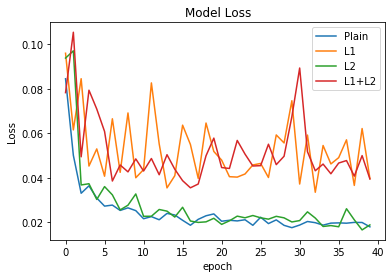

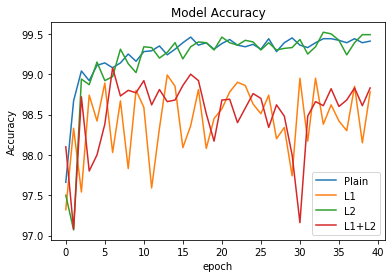

In [0]:
# summarize history for accuracy
plt.plot(test_losses[0])
plt.plot(test_losses[1])
plt.plot(test_losses[2])
plt.plot(test_losses[3])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Plain', 'L1', 'L2', 'L1+L2'], loc='best')
plt.show()

# summarize history for loss
plt.plot(test_acc[0])
plt.plot(test_acc[1])
plt.plot(test_acc[2])
plt.plot(test_acc[3])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Plain', 'L1', 'L2', 'L1+L2'], loc='best')
plt.show()

## Misclassfied images

In [234]:
my_misclassified_images = torch.rand(25,28,28) * 0
ground_truth = torch.rand(25,1)*0
classified_lie = torch.rand(25,1)*0
num_false_images = 0

def mis_classfied(model, device, test_loader):
    global num_false_images
    global ground_truth
    global classified_lie
    
    model.eval()

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            false_picker = torch.flatten(pred)-target
            index = 0
            for val in false_picker:
                if (val != 0):
                    my_misclassified_images[num_false_images] = data[index, 0, :, :]
                    ground_truth[num_false_images] = target[index]
                    classified_lie[num_false_images] = pred[index]
                    num_false_images = num_false_images + 1
                    if (num_false_images >= 25): 
                        break

                index = index + 1
               
            if (num_false_images >= 25):
                  break


mis_classfied(model_1, device, test_loader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


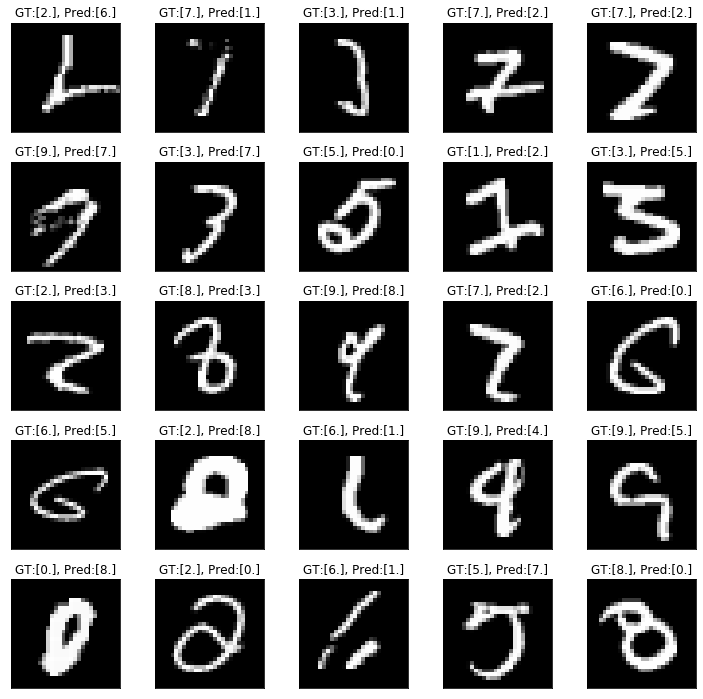

In [235]:
num_img_rows = 5
num_img_cols = 5

fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)

for i in range(25):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(my_misclassified_images[i,:,:], cmap='gray', interpolation='none')
  plt.title("GT:{}, Pred:{}".format(ground_truth[i].numpy(), classified_lie[i].numpy()))
  plt.xticks([])
  plt.yticks([])
